In [27]:
import numpy as np
import cv2 
import math 
import scipy.misc 
import PIL.Image
from sklearn import linear_model, datasets 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [49]:
def get_filepath(idx):
    filelist = os.listdir(samples_dir)
    return samples_dir + '/' + filelist[idx]

#get a line from a point and unit vectors 
def lineCalc(vx, vy, x0, y0): 
    '''scale = 10 
    x1 = x0+scale*vx 
    y1 = y0+scale*vy 
    m = (y1-y0)/(x1-x0) 
    b = y1-m*x1 '''
    
    m = vy / vx
    b = y0 - m * x0
    
    return m,b 

#vanishing point - cramer's rule 
def lineIntersect(m1,b1, m2,b2) :  
    #a1*x+b1*y=c1 
    #a2*x+b2*y=c2 
    #convert to cramer's system 
    a_1 = -m1  
    b_1 = 1 
    c_1 = b1 

 
    a_2 = -m2 
    b_2 = 1 
    c_2 = b2 

 
    d = a_1*b_2 - a_2*b_1 #determinant 
    dx = c_1*b_2 - c_2*b_1 
    dy = a_1*c_2 - a_2*c_1 

 
    intersectionX = dx/d 
    intersectionY = dy/d 
    return intersectionX,intersectionY 

#select Rifgt or Left
def selectLR(bxLeft, byLeft, bxRight, byRight, bxbyLeftArray, bxbyRightArray):
    
    #bxLeft, byLeft select
    avg_xL = np.sum(bxLeft) / np.array(bxLeft).size
    avg_xR = np.sum(bxRight) / np.array(bxRight).size
    bxLeft_L = []
    bxLeft_R = []
    bxRight_L = []
    bxRight_R = []
    

    byLL = []
    byLR = []
    
    byRL = []
    byRR = []
    
    # bxLeft 중 왼쪽 횡단보도와 오른쪽 횡단보도 분리
    for x in bxLeft:
        index = bxLeft.index(x)
        if x < avg_xL:
            bxLeft_L.append(x)
            byLL.append(byLeft[index])
        else:
            bxLeft_R.append(x)
            byLR.append(byLeft[index])

    # bxRight 중 왼쪽 횡단보도와 오른쪽 횡단보도 분리
    for x in bxRight:
        index = bxRight.index(x)
        if x < avg_xR:
            bxRight_L.append(x)
            byRL.append(byRight[index])
        else:
            bxRight_R.append(x)
            byRR.append(byRight[index])       
            
    
    #둘 중 더 많이 잡힌 부분을 선택        
    state = ''
    if np.array(bxLeft_L).size <= np.array(bxLeft_R).size :
        state = 'R'
    else:
        state = 'L'
    
    if state == 'R' :
        n_bxLeft = bxLeft_R
        n_byLeft = byLR
        n_bxRight = bxRight_R
        n_byRight = byRR
    elif state == 'L' :
        n_bxLeft = bxLeft_L
        n_byLeft = byLL
        n_bxRight = bxRight_L
        n_byRight = byRL
    
   
    n_bxbyLeftArray = []
    n_bxbyRightArray = []
    index = np.array(n_bxLeft).size
    for i in range(index):
        n_bxbyLeftArray.append([n_bxLeft[i], n_byLeft[i]])
    
    index = np.array(n_bxRight).size
    for i in range(index):
        n_bxbyRightArray.append([n_bxRight[i], n_byRight[i]])
    
    return n_bxLeft, n_byLeft, n_bxRight, n_byRight, n_bxbyLeftArray, n_bxbyRightArray
    

#process a frame 
def process(im): 
    try:
        #initialize some variables 
        W = 800
        H = 480
        x = W
        y = H


        radius = 250 #px 
        thresh = 170  
        bw_width = 170  


        bxLeft = [] 
        byLeft = [] 
        bxbyLeftArray = [] 
        bxbyRightArray = [] 
        bxRight = [] 
        byRight = [] 
        boundedLeft = [] 
        boundedRight = [] 

        #1. filter the white color 
        lower = np.array([130,130,130]) 
        upper = np.array([255,255,255]) 
        #ret, mask = cv2.threshold(im, 130, 255, cv2.THRESH_BINARY)
        #print(mask[1])
        mask = cv2.inRange(im,lower,upper) 
        
        #프레임에서 흰색 부분만 검출해냄 (170,170,170) ~ (255, 255, 255)
        #2. erode the frame 
        erodeSize = int(y / 30) 
        erodeStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (erodeSize,1)) 
        erode = cv2.erode(mask, erodeStructure, (-1, -1)) 
        # contour는 추출해낸 각 흰색 덩어리
        #3. find contours and  draw the green lines on the white strips 
        _ , contours,hierarchy = cv2.findContours(erode,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE )
        
        for i in contours: 
            bx,by,bw,bh = cv2.boundingRect(i) #직사각형 모양으로 contour의 정보를 추출해낸다. bx, by 는 시작점, bw, bh는 각각 가로, 세로의 길이 

            if (bw > bw_width): 

                cv2.line(im,(bx,by),(bx+bw,by),(0,255,0),2) # draw the a contour line    #횡단보도의 녹색 선
                bxRight.append(bx+bw) #right line     #녹색 선의 오른쪽 끝점 x좌표
                byRight.append(by) #right line        #녹색 선의 오른쪽 끝점 y좌표
                bxLeft.append(bx) #left line          #녹색 선의 왼쪽 끝점 x좌표
                byLeft.append(by) #left line          #녹색 선의 왼쪽 끝점 y좌표
                #bxbyLeftArray.append([bx,by]) #x,y for the left line    #왼쪽 끝점의 (x, y) 정보
                #bxbyRightArray.append([bx+bw,by]) # x,y for the left line   #오른쪽 끝점의 (x, y) 정보
                cv2.circle(im,(int(bx),int(by)),5,(0,250,250),2) #circles -> left line   #왼쪽 끝점에 circle
                cv2.circle(im,(int(bx+bw),int(by)),5,(0,250,250),2) #circles -> right line #오른쪽 끝점에 circle

        min_y = np.min(byLeft)
        
        plt.imshow(im)
        plt.show()
        
        bxLeft , byLeft, bxRight, byRight, bxbyLeftArray, bxbyRightArray = selectLR(bxLeft, byLeft, bxRight, byRight, bxbyLeftArray, bxbyRightArray)
        
        #calculate median average for each line 
        medianR = np.median(bxbyRightArray, axis=0) #y축 따라서 중점을 구함
        medianL = np.median(bxbyLeftArray, axis=0) 

        bxbyLeftArray = np.asarray(bxbyLeftArray) 
        bxbyRightArray = np.asarray(bxbyRightArray) 



        #4. are the points bounded within the median circle? 
        for i in bxbyLeftArray: 
            if (((medianL[0] - i[0])**2 + (medianL[1] - i[1])**2) < radius**2) == True: #각 왼쪽점 ~ 왼쪽 중점의 거리가 250 픽셀 이내인가?
                boundedLeft.append(i) 


        boundedLeft = np.asarray(boundedLeft) 


        for i in bxbyRightArray: 
            if (((medianR[0] - i[0])**2 + (medianR[1] - i[1])**2) < radius**2) == True: 
                boundedRight.append(i) 


        boundedRight = np.asarray(boundedRight) 


        #5. RANSAC Algorithm   # RANdom SAmple Consensus   # http://darkpgmr.tistory.com/61 참고

        #select the points enclosed within the circle (from the last part) 
        bxLeft = np.asarray(boundedLeft[:,0]) 
        byLeft =  np.asarray(boundedLeft[:,1])  
        bxRight = np.asarray(boundedRight[:,0])  
        byRight = np.asarray(boundedRight[:,1]) 


        #transpose x of the right and the left line 
        bxLeftT = np.array([bxLeft]).transpose() 
        bxRightT = np.array([bxRight]).transpose() 


        #run ransac for LEFT 
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression()) 
        ransacX = model_ransac.fit(bxLeftT, byLeft) 
        inlier_maskL = model_ransac.inlier_mask_ #right mask 


        #run ransac for RIGHT 
        ransacY = model_ransac.fit(bxRightT, byRight) 
        inlier_maskR = model_ransac.inlier_mask_ #left mask 


        #6. Calcuate the intersection point of the bounding lines 
        #unit vector + a point on each line 
        vx, vy, x0, y0 = cv2.fitLine(boundedLeft[inlier_maskL],cv2.DIST_L2,0,0.01,0.01)  
        vx_R, vy_R, x0_R, y0_R = cv2.fitLine(boundedRight[inlier_maskR],cv2.DIST_L2,0,0.01,0.01) 


        #get m*x+b 
        m_L,b_L=lineCalc(vx, vy, x0, y0) 
        m_R,b_R=lineCalc(vx_R, vy_R, x0_R, y0_R) 


        #calculate intersention  
        intersectionX,intersectionY = lineIntersect(m_R,b_R,m_L,b_L) 

        #8. calculating the direction vector   
        POVx = W/2 #camera POV - center of the screen 
        POVy = H/2 # camera POV - center of the screen 


        Dx = -int(intersectionX-POVx) #regular x,y axis coordinates 
        Dy = -int(intersectionY-POVy) #regular x,y axis coordinates 


        #focal length in pixels = (image width in pixels) * (focal length in mm) / (CCD width in mm)  # 초점거리
        focalpx = int(W * 4.26 / 6.604) #all in mm 


        #print('DELTA (x,y from POV):' + str(Dx) + ',' + str(Dy)) 
        return Dx,Dy,min_y
    
    except ValueError:
        return None, None, None

def detector(img_arr):
    H, W, _ = img_arr[0].shape
    DxAve = 0
    DyAve = 0
    Dxold = 0
    Dyold = 0
    Dx = []
    Dy = []
    i = 0
    end = False
    state = 'S'
    scale = 0
    count = 0
    arr_min_y = []
    
    for n in range(len(img_arr)) :
        dx,dy, min_y = process(img_arr[n])
        if dx == None:
            continue
            
        

        Dx.append(dx) 
        Dy.append(dy) 
        DxAve = sum(Dx)/len(Dx)
        DyAve = sum(Dy)/len(Dy)    



        if (DyAve > 30) and (abs(DxAve) < 300):         
            #check if the vanishing point and the next vanishing point aren't too far from each other  
            if (((DxAve - Dxold)**2 + (DyAve - Dyold)**2) < 150**2) == True:  ##distance 150 px max  

                #walking directions 
                if abs(DxAve) < 80 and DyAve > 100 and abs(Dxold-DxAve) < 20: 
                    state = 'S' 


                elif DxAve > 80 and DyAve > 100 and abs(Dxold-DxAve) < 20: 
                    state = 'R' 


                elif DxAve < 80 and DyAve > 100 and abs(Dxold-DxAve) < 20: 
                    state = 'L'

                scale += DxAve - Dxold
            count += 1
            Dxold = DxAve
            Dyold = DyAve
            
    
    if count != 0:
        end = True
        scale = scale / count
    #min_y = np.max(arr_min_y)
    
    
    
    
    #if(min_y > H / 2):
        #end = True
    #else:
        #end = False
        
    return (end, state, scale) #True = 끝나감, scale > 0 오른쪽

In [48]:
import time

if __name__ == '__main__':
    before = time.time()
    img_arr = []
    for n in range(3):
        prepath = './test/'
        filepath = prepath + 'g.jpg'#str(n) + '.jpg'
        img = cv2.imread(filepath)
        img_arr.append(img)

    print(detector(img_arr))
    print(time.time() - before)

[[255 255 255]
 [255 255 255]
 [255 255 255]
 ..., 
 [255 255 255]
 [255 255 255]
 [255 255 255]]


AttributeError: module 'cv2.cv2' has no attribute 'cvStartFindContours_Impl'

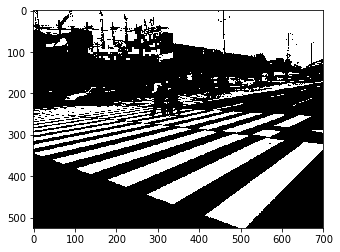

In [45]:
prepath = './test/'
imgg = cv2.imread(prepath + 'g.jpg')
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, 'gray')
plt.show()